# Collecting and Graphing English Wikipedia page views 2007-2021

#### This code is made available for re-use under a [MIT license](https://opensource.org/licenses/MIT)

# Imports

In [1]:
import requests
import json
import pandas as pd
from matplotlib import rcParams
import matplotlib.pyplot as plt
import numpy as np

# Data acquisition

The project pulls data from Wikimedia's API. We leverage two endpoints:
1.  Legacy Pagecounts API ([documentation]( https://wikitech.wikimedia.org/wiki/Analytics/AQS/Legacy_Pagecounts), [endpoint](https://wikimedia.org/api/rest_v1/#/Pagecounts_data_(legacy)/get_metrics_legacy_pagecounts_aggregate_project_access_site_granularity_start_end) ))

2. PageView API ([documentation](https://wikitech.wikimedia.org/wiki/Analytics/AQS/Pageviews), [endpoint](https://wikimedia.org/api/rest_v1/#/Pageviews_data/get_metrics_pageviews_aggregate_project_access_agent_granularity_start_end))

Visit the hyperlinks to learn more about the api endpoints and their respective parameters.

### Define Wikimedia endpoints

In [2]:
pagecount_endpoint = 'https://wikimedia.org/api/rest_v1/metrics/legacy/pagecounts/aggregate/{project}/{access-site}/{granularity}/{start}/{end}'

pageview_endpoint = 'https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/{project}/{access}/{agent}/{granularity}/{start}/{end}'
headers = {
    'User-Agent': 'https://github.com/savageGrant',
    'From':'gtsavage@uw.edu'
}

### Define API Parameters
define two sets of parameters, one for each API we leverage
We will be making a call for each access type we want to collect information on.

For the Legacy Pagecount API we will collect data on access types:
1. desktop-site
2. mobile-site

For the Pageview API we will collect data on access types:
1. desktop
2. mobile-web
3. mobile-app

In [3]:
# Legacy pagecount API params
legacy_pagecount = """{{"project" : "en.wikipedia.org",
                 "access-site" : "{placeholder}",
                 "granularity" : "monthly",
                 "start" : "2008010100",
                 "end" : "2016080100"
                    }}"""

legacy_pagecount_access_types = ['desktop-site', 'mobile-site']

# Pageview API params
pageview = """{{"project" : "en.wikipedia.org",
                 "access" : "{placeholder}",
                 "agent" : "user",
                 "granularity" : "monthly",
                 "start" : "2015070100",
                 "end" : "2021090100"
                    }}"""


pageview_access_types = ['desktop', 'mobile-web', 'mobile-app']

### Make the API calls for each of the access types and save to json files

In [4]:
def api_call(endpoint,parameters):
    call = requests.get(endpoint.format(**parameters), headers=headers)
    response = call.json()
    
    return response

### Runs two For loops, one for each API endpoint. 

### For each endpoint this makes a call for each desired access type. 


### Saves the output of each call to a .json file in data_raw folder. Copy the data to the dataframes dictionary with the access_type value as the key.

The json naming covention used is apiname_accesstype_firstmonth-lastmonth.json

In [5]:
dataframes = {}

#loop over each access type and make an api_call. Save output to file and copy to the dataframes dictionary.

#legacy pagecount API calls
for access_type in legacy_pagecount_access_types:
    api_params = json.loads(legacy_pagecount.format(placeholder=access_type))
    monthly_pagecount = api_call(pagecount_endpoint, api_params)['items']
    dataframes[access_type] = pd.DataFrame(monthly_pagecount)
    with open('data_raw/pagecounts_{}_20080101-20160801.json'.format(access_type), 'w') as json_file:
        json.dump(monthly_pagecount, json_file)

#pageview API calls
for access_type in pageview_access_types:
    api_params = json.loads(pageview.format(placeholder=access_type))
    monthly_pageview = api_call(pageview_endpoint, api_params)['items']
    dataframes[access_type] = pd.DataFrame(monthly_pageview)
    with open('data_raw/pageviews_{}_200150701-20210901.json'.format(access_type), 'w') as json_file:
        json.dump(monthly_pageview, json_file)

# Data processing

This section cleans the raw data and combines the 5 dataframes that were created in the previous step into one final dataframe.

### Rename columns and combine pageview mobile-web and pageview mobile-app data into single pageview_mobile_views column.

In [6]:
#legacy_pagecount desktop-site
dataframes['desktop-site'].rename(columns={'count':'pagecount_desktop_views'}, inplace=True)
# legacy_pagecount mobile-site
dataframes['mobile-site'].rename(columns={'count':'pagecount_mobile_views'}, inplace=True)
# pageview desktop
dataframes['desktop'].rename(columns={'views':'pageview_desktop_views'}, inplace=True)
# pageview mobile combines both mobile-web and mobile-app into a single dataframe
mobile_pageview = pd.concat([dataframes['mobile-web'], dataframes['mobile-app']])\
       .groupby('timestamp')['views']\
       .sum().reset_index()
mobile_pageview.rename(columns={'views':'pageview_mobile_views'}, inplace=True)

### Merge dataframes into a final frame and drop unnecessary columns

In [7]:
final_df = mobile_pageview.merge(dataframes['desktop'],how='outer', on='timestamp').merge(dataframes['mobile-site'], how='outer', on='timestamp').merge(dataframes['desktop-site'], how='outer', on='timestamp')
final_df = final_df[['timestamp','pagecount_mobile_views','pagecount_desktop_views','pageview_mobile_views', 'pageview_desktop_views']]

### Create two new columns, summing the views across access type for the pagecount and the pageview APIs. 

In [8]:
final_df['pagecount_all_views'] = final_df['pagecount_mobile_views'].fillna(0) + final_df['pagecount_desktop_views'].fillna(0)
final_df['pageview_all_views'] = final_df['pageview_mobile_views'].fillna(0) + final_df['pageview_desktop_views'].fillna(0)

### Extracting year and month from timestamp, sorting the dataframe then droping the timestamp column

In [9]:
final_df['year'] = final_df['timestamp'].str[:4]
final_df['month'] = final_df['timestamp'].str[4:6]
final_df = final_df.sort_values(by=['timestamp'])
final_df.drop(columns=['timestamp'],inplace=True)

### Save the cleaned data to a CSV.

Note: The csv has 0 values in rows where data does not exist, the dataframe has np.nans. This is intentional because the np.nans create a more attractive graph.

In [10]:
final_df.fillna(0).to_csv('data_clean/en-wikipedia_traffic_200712-202108.csv')

#  Analysis

This is a simple plot of the data over time. I leverage matplotlib to generate the graph.

<Figure size 864x576 with 0 Axes>

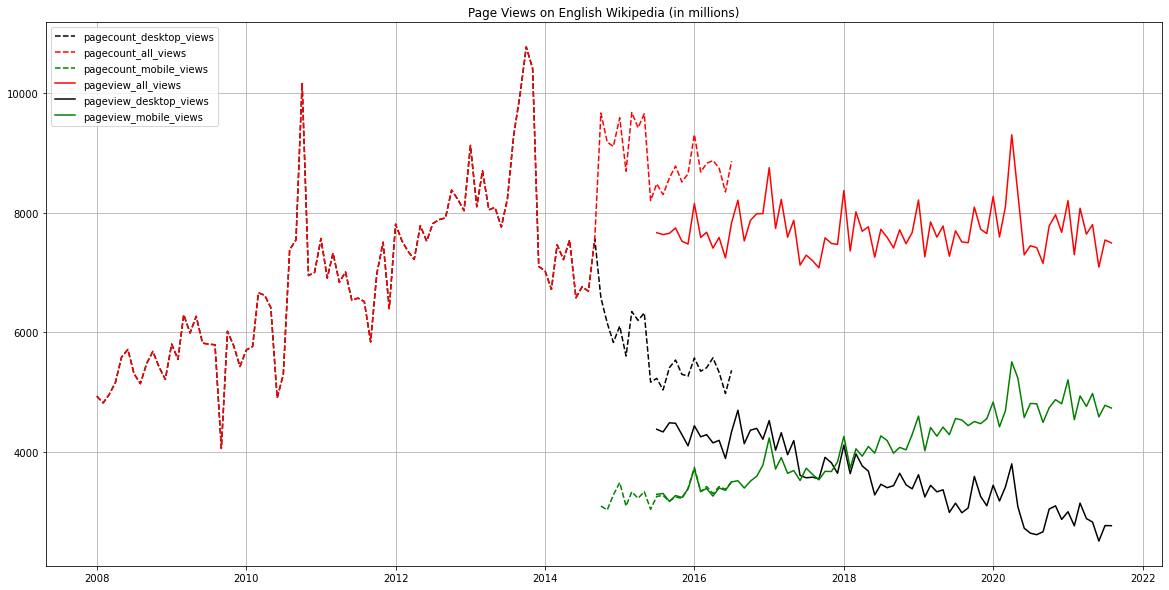

<Figure size 864x576 with 0 Axes>

In [11]:
# Date column makes plotting significantly easier
final_df['Date'] = pd.to_datetime([f'{y}-{m}-01' for y, m in zip(final_df.year, final_df.month)])
# removes zeros for styling graph
final_df = final_df.replace(0,np.nan)

#plot
rcParams['figure.figsize'] = [20, 10]
plt.figure()
plt.ticklabel_format(style='plain')
plt.plot(final_df.Date, final_df.pagecount_desktop_views/1e6, color = 'black', linestyle = 'dashed', label='pagecount_desktop_views')
plt.plot(final_df.Date, final_df.pagecount_all_views/1e6, color = 'red', linestyle = 'dashed', label='pagecount_all_views')
plt.plot(final_df.Date, final_df.pagecount_mobile_views/1e6, color = 'green', linestyle = 'dashed', label='pagecount_mobile_views')
plt.plot(final_df.Date, final_df.pageview_all_views/1e6, color = 'red', linestyle = 'solid',label='pageview_all_views')
plt.plot(final_df.Date, final_df.pageview_desktop_views/1e6, color = 'black', linestyle = 'solid',label='pageview_desktop_views')
plt.plot(final_df.Date, final_df.pageview_mobile_views/1e6, color = 'green', linestyle = 'solid',label='pageview_mobile_views')
plt.legend(loc = "upper left")
plt.title('Page Views on English Wikipedia (in millions)')
plt.grid(True)
plt.figure(figsize=(12,8))